In [120]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [121]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 
    return coordinates, elements3,dirichlet, neumann

In [122]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [123]:
#calcul de la matrice de raideur élémentaire relative à un élément triangle 
def matrice_raideur(sommets):
    A,B,C= sommets
    alpha = np.linalg.det(np.array([B-A, C-A]).T)
    # Aire du triangle
    T=alpha/2
    m = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            delta_eta_i= (1/alpha) * np.array([[sommets[(i+1)%3][1]-sommets[(i+2)%3][1]], [sommets[(i+2)%3][0]-sommets[(i+1)%3][0]]])
            delta_eta_j= (1/alpha) * np.array([[sommets[(j+1)%3][1]-sommets[(j+2)%3][1]], [sommets[(j+2)%3][0]-sommets[(j+1)%3][0]]])
            # Calcul du coefficient de la matrice de raideur élémentaire
            m[i][j]=T*(np.transpose(delta_eta_i).dot(delta_eta_j))
    return m,alpha

In [124]:
#Assemblage de la matrice A dans le cas d’un maillage constitué uniquement de triangle 
# en entrée : les coordonnées des points du maillage et les éléments du maillage
def f (x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)
def ud (x,y):
    return 10

def assemblage_matrice_raideur(coordinates,elements3, dirichlet, n):
    l,_ = np.shape(coordinates)
    a = np.zeros((l,l))
    b = np.zeros((l,1))
    for e in elements3:
        sommets = [coordinates[i] for i in e]
        # matrice de raideur élémentaire
        m, alpha = matrice_raideur(sommets)
        # centre de gravité des triangles 
        xg, yg = np.mean(sommets, axis=0)
        for i in range(3):
            for j in range(3):
                a[e[i]][e[j]] += m[i][j]
            b[e[i]] += (alpha/6)*f(xg,yg)


    # vecteur U  contient les Uk : ils valent les ud car on est sur la frontière de Dirichlet
    U = np.zeros((l,1))
    print(dirichlet)
    ld,_= np.shape(dirichlet)
    for i in range(ld):
        k=dirichlet[i,0]
        U[k]= ud(coordinates[k,0],coordinates[k,1]) 
    # on modifie le vecteur b en enlevant les lignes correspondant aux points de Dirichlet
    b = b-np.dot(a,U)
    
    sommets2 = [i for i in range(n*n) if i not in dirichlet]
    a_aux = a[sommets2]
    a_aux = a_aux.T[sommets2].T
    b_aux = b[sommets2]
    return a_aux,b_aux,U,sommets2



[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [19]
 [29]
 [39]
 [49]
 [59]
 [69]
 [79]
 [89]
 [99]
 [98]
 [97]
 [96]
 [95]
 [94]
 [93]
 [92]
 [91]
 [90]
 [80]
 [70]
 [60]
 [50]
 [40]
 [30]
 [20]
 [10]]


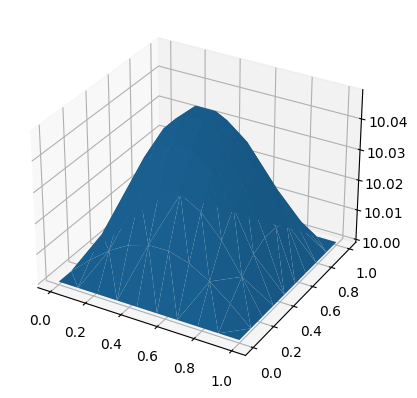

Erreur :  99.99724516705733


In [125]:
n = 10
coordinates, elements3, dirichlet, neumann = maillage(n)
a,b,U,sommets = assemblage_matrice_raideur(coordinates, elements3, dirichlet, n)
u = np.linalg.solve(a,b)

u_complet = np.zeros(n*n)
u_complet[sommets] = u[:,0]
for i in dirichlet:
    u_complet[i[0]] = ud(coordinates[i[0],0],coordinates[i[0],1])
    
show(coordinates,u_complet)
erreur = np.linalg.norm(f(coordinates[:,0],coordinates[:,1])/(2*np.pi**2) - u_complet)
print("Erreur : ",erreur)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [126]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [127]:
#calcul de la matrice de raideur élémentaire relative à un élément triangle 
def matrice_raideur_quadrangle(sommets):
    A,B,C,D= sommets
    J = np.array([B-A, C-A]).T
    alpha = np.linalg.det(J)
    Jinv = np.linalg.inv(np.dot(J,J.T))
    a,b,c = Jinv[0][0], Jinv[0][1], Jinv[1][1]
    m = np.zeros((4,4))
    m[0][0] = 2*a+3*b+2*c
    m[0][1] = -2*a+c
    m[0][2] = -a-3*b-c
    m[0][3] = a-2*c
    m[1][0] = m[0][1]
    m[1][1] = 2*a-3*b+2*c
    m[1][2] = a-2*c
    m[1][3] = -a+3*b-c 
    m[2][0] = m[0][2]
    m[2][1] = m[1][2]
    m[2][2] = m[0][0] 
    m[2][3] = -2*a+c
    m[3][0] = m[0][3]
    m[3][1] = m[1][3]
    m[3][2] = m[2][3]
    m[3][3] = m[1][1]

    m = m*(alpha/6)

    return m,alpha

In [128]:
#Assemblage de la matrice A dans le cas d’un maillage constitué uniquement de triangle 
# en entrée : les coordonnées des points du maillage et les éléments du maillage
def f (x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)
def ud (x,y):
    return 0
def g (x,y):
    return 0

def assemblage_matrice_mixte(elements3, elements4, dirichlet, neumann, coordinates):
    l,_ = np.shape(coordinates)
    a = np.zeros((l,l))
    b = np.zeros((l,1))
    for e in elements3:
        sommets = [coordinates[i] for i in e]
        # matrice de raideur élémentaire
        m, alpha = matrice_raideur(sommets)
        # centre de gravité des triangles 
        xg, yg = np.mean(sommets, axis=0)
        for i in range(3):
            for j in range(3):
                a[e[i]][e[j]] += m[i][j]
            b[e[i]] += (alpha/6)*f(xg,yg)

    for e in elements4:
        sommets = [coordinates[i] for i in e]
        # matrice de raideur élémentaire
        m, alpha = matrice_raideur_quadrangle(sommets)
        # centre de gravité des quadrangles 
        xg, yg = np.mean(sommets, axis=0)
        for i in range(4):
            for j in range(4):
                a[e[i]][e[j]] += m[i][j]
            b[e[i]] += (alpha/4)*f(xg,yg)


    # vecteur U  contient les Uk : ils valent les ud car on est sur la frontière de Dirichlet
    U = np.zeros((l,1))
    ld = len(dirichlet)
    for i in range(ld):
        k=dirichlet[i]
        U[k]= ud(coordinates[k,0],coordinates[k,1]) 
    # on modifie le vecteur b en enlevant les lignes correspondant aux points de Dirichlet
    b = b-np.dot(a,U)

    for i1, i2 in neumann:
        x1 = coordinates[i1][0] 
        y1 = coordinates[i1][1]
        x2 = coordinates[i2][0]
        y2 = coordinates[i2][1]
        b[i1] += g(x1,y1)*np.sqrt((x2-x1)**2+(y2-y1)**2)/2
        b[i2] += g(x2,y2)*np.sqrt((x2-x1)**2+(y2-y1)**2)/2
    
    sommets2 = [i for i in range(n*n) if i not in dirichlet[:,0]]
    print(sommets2)
    a_aux = a[sommets2]
    a_aux = a_aux.T[sommets2].T
    b_aux = b[sommets2]
    return a_aux,b_aux,U,sommets2



In [129]:
n = 10
print(np.shape(dds))
a,b,U,sommets = assemblage_matrice_mixte(e3, e4, dds, nns, ccs)
u = np.linalg.solve(a,b)

u_complet = np.zeros(n*n)
u_complet[sommets] = u[:,0]
for i in dirichlet:
    u_complet[i[0]] = ud(coordinates[i[0],0],coordinates[i[0],1])
    
show(coordinates,u_complet)
erreur = np.linalg.norm(f(coordinates[:,0],coordinates[:,1])/(2*np.pi**2) - u_complet)
print("Erreur : ",erreur)

(10,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

**Compléments  :  un nouveau terme dans l'EDP**